In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader



In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
torch.manual_seed(1)
print(device)

mps


In [3]:
data = np.load("./data/ae_data.npz")

Str = data["Str"]
Xtr = torch.from_numpy(data["Xtr"]).type(torch.int)
Ytr = torch.from_numpy(data["Ytr"]).type(torch.float)

Ste = data["Ste"]
Xte = torch.from_numpy(data["Xte"]).type(torch.int)
Yte = torch.from_numpy(data["Yte"]).type(torch.float)

In [4]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim):
        super(TransformerModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(input_dim, d_model)

        # Transformer model
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers)

        # Linear output layer
        self.output = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # Prepare the input tensor for the transformer model
        x = self.embedding(x)
        x = x.permute(1, 0, 2)

        # Forward propagate transformer model
        out = self.transformer(x, x)

        # Decode the output of the transformer model
        out = self.output(out[-1, :, :])

        return out

In [5]:
class ArithmeticExpressionDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y



In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(Xtr, Ytr, test_size=0.2)

train_dataset = ArithmeticExpressionDataset(X_train, Y_train)
val_dataset = ArithmeticExpressionDataset(X_val, Y_val)

# Create data loaders for training and validation
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [7]:
output_vocab_size=1
num_features=13
d_model=64
nhead=4
num_layers=4
model = TransformerModel(num_features,d_model,nhead,num_layers,output_vocab_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Define the loss function
criterion = nn.MSELoss()

In [8]:
val_loss_list=[]
train_loss_list=[]
# Train the model
epochs = 1000
for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    model.train()  # set the model to training mode
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)
    train_loss_list.append(train_loss)
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item() * x.size(0)
        val_loss /= len(val_dataset)
        val_loss_list.append(val_loss)
    


    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))


Epoch [1/1000], Train Loss: 207282.8617, Val Loss: 191866.3227
Epoch [2/1000], Train Loss: 188633.6627, Val Loss: 188994.8092
Epoch [3/1000], Train Loss: 188312.2085, Val Loss: 188953.6089
Epoch [4/1000], Train Loss: 188307.5800, Val Loss: 188965.2516
Epoch [5/1000], Train Loss: 188304.2548, Val Loss: 188953.9068
Epoch [6/1000], Train Loss: 188295.5712, Val Loss: 188984.6981
Epoch [7/1000], Train Loss: 188305.5356, Val Loss: 188972.2552
Epoch [8/1000], Train Loss: 188297.2342, Val Loss: 188987.3893
Epoch [9/1000], Train Loss: 188301.6283, Val Loss: 188955.4251
Epoch [10/1000], Train Loss: 188304.5099, Val Loss: 189016.3532
Epoch [11/1000], Train Loss: 188311.2674, Val Loss: 188954.1896
Epoch [12/1000], Train Loss: 188299.0313, Val Loss: 188970.7957
Epoch [13/1000], Train Loss: 188306.1633, Val Loss: 188955.6313
Epoch [14/1000], Train Loss: 188301.5314, Val Loss: 188953.4036
Epoch [15/1000], Train Loss: 188307.9870, Val Loss: 188954.2195
Epoch [16/1000], Train Loss: 188308.5697, Val Los

In [13]:
import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss, epochs):
    """
    Plots the training and validation loss against the number of epochs.

    Args:
        train_loss (list): List of training loss values.
        val_loss (list): List of validation loss values.
        epochs (int): Number of epochs trained for.

    Returns:
        None
    """
    plt.plot(range(1, epochs+1), train_loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()



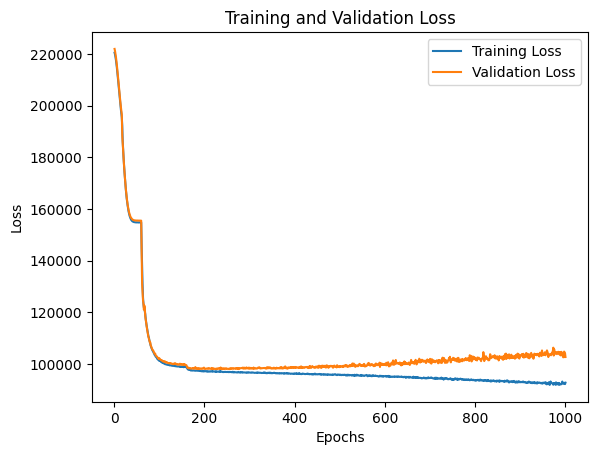

In [14]:
plot_loss(train_loss_list,val_loss_list,epochs)